**LCEL 인터페이스**

    - 사용자 정의 체인을 쉽게 만들도록 `Runnable` 프로토콜 구현
    - 표준 인터페이스로 사용자 정의 체인을 정의하고 표준 방식으로 호출하게 함 
     : `stream`, `invoke`, `batch` 
     `stream` - 응답의 청크를 스트리밍
     `invoke` - 입력에 대한 체인 호출
     `batch` - 입력 목록에 대한 체인 호출

    - 비동기 메소드 
    `astream` : 비동기로 응답의 청크 스트리밍
    `ainvoke` : 비동기로 입력에 대한 체인 호출
    `abatch` : 비동기로 입력 목록에 대한 체인 호출
    `astream_log` : 최종 응답뿐 아니라 발생하는 중간 단계 스트리밍


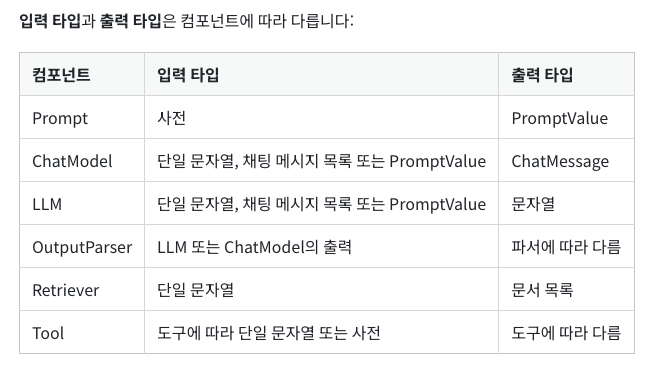

    모든 runnable은 입력과 출력 스키마를 노출해서 입력과 출력을 검사함
    - `input_schema` : Runnable 구조에서 자동 생성된 입력 Pydantic 모델
    - `output_schema` : Runnable 구조에서 자동 생성된 출력 Pydantic 모델

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# langchain 라이브러리를 사용해 챗봇 모델을 구성. ChatOpenAI 클래스를 사용해 OpenAI 챗봇 모델의 인스턴스를 생성함
# ChatPromptTemplate 클래스를 사용해 특정 주제에 대한 농담을 요청하는 프롬프트 템플릿을 만듦
# 그 후에 프롬프트와 모델을 파이프 연산자 (|) 로 사용해 연결해 대화 체인을 구성함
# 해당 체인을 통해 사용자는 주제를 입력해 관련 농담을 생성하는 챗봇과 상호작용 함

from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

In [3]:
model = ChatOpenAI(model='gpt-3.5-turbo')
prompt = ChatPromptTemplate.from_template("{topic}에 대하여 3문장으로 설명해줘")
chain = prompt | model

In [5]:
chain

ChatPromptTemplate(input_variables=['topic'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['topic'], template='{topic}에 대하여 3문장으로 설명해줘'))])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x124643310>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x11091f490>, openai_api_key=SecretStr('**********'), openai_proxy='')

**입력 스키마**
    
    - Runnable에 의해 수락된 입력들에 대한 설명으로, Runnable 구조로부터 동적으로 생성된 Pydantic 모델
    - JSONSchema 표현을 얻기 위해 `.schema()` 를 호출할 수 있음

    `chain` 객체의 `input_schema` 속성을 사용해 체인의 첫 번째 부분인 프롬프트의 입력 스키마를 조회한다
    `schema()` 메서드를 호출해 해당 스키마의 구조를 얻을 수 있다.

In [7]:
# 체인의 입력 스키마는 첫 번째 부분인 프롬프트 입력 스키마이다.

chain.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'topic': {'title': 'Topic', 'type': 'string'}}}

    
    JSON 스키마 정의, 해당 스키마를 출력하기
    `input_schema`는 'name', 'age'를 가진 객체를 기술하는 스키마이고 이 필드는 필수 요소
    'name' 필드는 문자열 'age' 필드는 정수 타입, 최소값은 0
    `print_schema` 함수는 인자로 받은 스키마를 JSOn 형식으로 콘솔에 출력
    `print_schema`는 `input_schema`를 인자로 받아 호출되어 스키마를 출력함


In [8]:
import json

def print_schema(schema):
    print(json.dumps(schema, indent=4))

input_schema = {
    "type" : "object",
    "properties" : {
        "name" : {"type": "string"},
        "age" : {"type" :"integer", "minium":0},
    },
    "required" : ["name", "age"]
}

print_schema(input_schema)

{
    "type": "object",
    "properties": {
        "name": {
            "type": "string"
        },
        "age": {
            "type": "integer",
            "minium": 0
        }
    },
    "required": [
        "name",
        "age"
    ]
}


In [9]:
model.input_schema.schema()

{'title': 'ChatOpenAIInput',
 'anyOf': [{'type': 'string'},
  {'$ref': '#/definitions/StringPromptValue'},
  {'$ref': '#/definitions/ChatPromptValueConcrete'},
  {'type': 'array',
   'items': {'anyOf': [{'$ref': '#/definitions/AIMessage'},
     {'$ref': '#/definitions/HumanMessage'},
     {'$ref': '#/definitions/ChatMessage'},
     {'$ref': '#/definitions/SystemMessage'},
     {'$ref': '#/definitions/FunctionMessage'},
     {'$ref': '#/definitions/ToolMessage'}]}}],
 'definitions': {'StringPromptValue': {'title': 'StringPromptValue',
   'description': 'String prompt value.',
   'type': 'object',
   'properties': {'text': {'title': 'Text', 'type': 'string'},
    'type': {'title': 'Type',
     'default': 'StringPromptValue',
     'enum': ['StringPromptValue'],
     'type': 'string'}},
   'required': ['text']},
  'AIMessage': {'title': 'AIMessage',
   'description': 'Message from an AI.',
   'type': 'object',
   'properties': {'content': {'title': 'Content',
     'anyOf': [{'type': 'strin

**출력 스키마**
    
    - Runnable에서 생성된 출력에 대한 설명
    - Runnable의 구조에서 동적으로 생성된 Pydantic model
    - `.shcema()`를 호출해 JSONshema 표현을 얻음


In [10]:
# 체인(chain)의 출력 스키마를 확인하는 예제로, 체인은 여러 처리 단계를 연결한 것이다.
# 마지막 단계의 출력 스키마가 전체 체인의 출력 스키마가 된다.
# 예시에서는 ChatModel이 마지막 단계이고, 이 모델은 ChatMessage를 출력한다.
# `chain.output_schema.schema()` 메서드을 호출하여 현재 체인의 출력 스키마를 조회할 수 있다.

In [11]:
chain.output_schema.schema()

{'title': 'ChatOpenAIOutput',
 'anyOf': [{'$ref': '#/definitions/AIMessage'},
  {'$ref': '#/definitions/HumanMessage'},
  {'$ref': '#/definitions/ChatMessage'},
  {'$ref': '#/definitions/SystemMessage'},
  {'$ref': '#/definitions/FunctionMessage'},
  {'$ref': '#/definitions/ToolMessage'}],
 'definitions': {'AIMessage': {'title': 'AIMessage',
   'description': 'Message from an AI.',
   'type': 'object',
   'properties': {'content': {'title': 'Content',
     'anyOf': [{'type': 'string'},
      {'type': 'array',
       'items': {'anyOf': [{'type': 'string'}, {'type': 'object'}]}}]},
    'additional_kwargs': {'title': 'Additional Kwargs', 'type': 'object'},
    'response_metadata': {'title': 'Response Metadata', 'type': 'object'},
    'type': {'title': 'Type',
     'default': 'ai',
     'enum': ['ai'],
     'type': 'string'},
    'name': {'title': 'Name', 'type': 'string'},
    'id': {'title': 'Id', 'type': 'string'},
    'example': {'title': 'Example', 'default': False, 'type': 'boolean'}

**steam: 실시간 출력**

    - `chain.stream` 메서드로 주어진 토픽에 대한 데이터 스트림 생성
    - 이 스트림을 반복하여 각 데이터의 내용(content)를 즉시 출력
    - `end=""` 인자는 출력 후 줄바꿈을 하지 않도록 출력, `flush=True`는 출력 버퍼를 즉시 비움 -> 스트리밍 데이터를 실시간으로 처리할 때 유용

In [13]:
for s in chain.stream({"topic": "멀티모달"}):
    print(s.content, end="", flush=True)

멀티모달은 여러 가지 형태의 정보를 통합하여 제공하는 시스템이다. 이는 여러 가지 감각을 이용하여 사용자에게 더 풍부한 경험을 제공한다. 예를 들어 음성, 시각, 촉각 등 다양한 감각을 활용하여 정보를 전달하고 상호작용할 수 있다.

**invoke : 호출**

    -  `chain` 객체의 `invoke` 메서드는 주제를 인자로 받아 해당 주제에 대한 처리를 수행

In [16]:
# `topic` 키에 `ChatGPT` 값을 가진 딕셔너리를 `invoke` 메소드에 전달함
chain.invoke({"topic":"ChatGPT"})

AIMessage(content='ChatGPT는 인공지능 챗봇으로, 자연어 처리 및 이해 기술을 사용하여 대화를 수행합니다. 사용자의 질문에 대답하고, 정보를 제공하며, 대화를 이어나갈 수 있습니다. ChatGPT를 통해 사용자는 다양한 주제에 대한 질문을 하고 대화를 나눌 수 있습니다.', response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 23, 'total_tokens': 132}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})

**batch : 단위 실행**

    - 여러 개의 딕셔너리를 포함하는 리스트를 인자로 받아, 각 딕셔너리에 있는 topic 키의 값을 사용해 일괄 처리 수행

In [17]:
chain.batch([{"topic":"ChatGPT"}, {"topic":"Instagram"}])

[AIMessage(content='ChatGPT는 인공지능 챗봇으로, 자연어 처리 기술을 사용하여 대화를 진행합니다. 사용자의 질문에 대답하거나 대화를 이어나가며 다양한 주제에 대해 대화할 수 있습니다. ChatGPT는 학습과 경험을 통해 점차적으로 더 나은 응답을 제공하며, 다양한 상황에서 유연하고 자연스러운 대화를 지원합니다.', response_metadata={'token_usage': {'completion_tokens': 140, 'prompt_tokens': 23, 'total_tokens': 163}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='Instagram은 사진과 동영상을 공유하는 소셜 미디어 플랫폼으로, 사용자들은 자신의 일상을 시각적으로 공유하고 다른 사람들과 소통할 수 있습니다. 해시태그를 활용하여 관심사에 맞는 콘텐츠를 찾을 수 있으며, 다양한 필터와 편집 기능을 통해 사진을 더욱 멋지게 편집할 수 있습니다. 인스타그램 스토리 기능을 통해 일시적인 콘텐츠를 공유하고, 라이브 방송을 통해 실시간으로 팔로워들과 소통할 수도 있습니다.', response_metadata={'token_usage': {'completion_tokens': 221, 'prompt_tokens': 21, 'total_tokens': 242}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})]

    `max_concurrency` 매개변수를 사용해서 동시 요청 수를 설정

    - `chain.batch`는 여러 작업을 동시에 처리할 수 있도록 배치 작업을 생성함.
    이 함수는 두 개의 인자를 받고 있는데, 작업 목록과 설정을 담은 `config`
    작업 목록은 딕셔너리의 리스트로, 각 딕셔너리는 처리할 주제를 나타내는 topic 키를 포함하고
    config 딕셔너리는 max_concurrency 키를 통해 동시에 처리할 수 있는 최대 작업 수를 설정함

In [21]:
# 최대 3개의 작업을 동시 처리하도록 설정

chain.batch(
    [
        {"topic" : "ChatGPT"},
        {"topic" : "Instagram"},
        {"topic" : "멀티모달"},
        {"topic" : "프로그래밍"},
        {"topic" : "머신러닝"},
    ],
    config = {"max_concurrency" : 3},
)

[AIMessage(content='ChatGPT는 OpenAI가 개발한 대화형 인공지능 모델로, 다양한 주제에 대한 대화를 이어나갈 수 있습니다. 이 모델은 자연어 처리 기술을 기반으로 작동하며, 사용자와 자연스럽고 효과적인 상호작용을 제공합니다. ChatGPT를 통해 사용자는 챗봇이나 가상 비서와 유사한 경험을 할 수 있습니다.', response_metadata={'token_usage': {'completion_tokens': 132, 'prompt_tokens': 23, 'total_tokens': 155}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='Instagram은 사진과 동영상을 공유하는 소셜 미디어 플랫폼으로, 사용자들은 자신의 일상을 담은 포스트를 업로드하고 다른 사람들과 소통할 수 있습니다. 또한 해시태그를 통해 특정 주제나 관심사에 관련된 콘텐츠를 찾을 수 있으며, 팔로워와 팔로잉을 통해 다양한 사람들을 만날 수 있습니다. 또한 인스타그램 스토리와 라이브 기능을 통해 실시간으로 소통하고 콘텐츠를 공유할 수 있습니다.', response_metadata={'token_usage': {'completion_tokens': 209, 'prompt_tokens': 21, 'total_tokens': 230}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='멀티모달은 여러 가지 형태의 정보를 결합하여 제공하는 시스템이다. 이는 텍스트, 이미지, 음성, 동영상 등 다양한 매체를 활용하여 사용자에게 정보를 전달한다. 멀티모달은 사용자 경험을 향상시키고 정보를 보다

**async stream : 비동기 스트림**

    - 비동기 스트림으로 주어진 토픽에 대한 메시지를 비동기적으로 처리
    비동기 for loop (async for)를 사용해 스트림에서 메시지를 순차적으로 받아오고, print 함수를 통해서 메시지 내용을 즉시 출력(s.content)
    end=""로 출력 후 줄바꿈하지 않도록 설정하고 flush=True로 출력 버퍼를 강제로 비워 즉시 출력함

In [23]:
async for s in chain.astream({"topic":"Youtube"}):
    print(s.content, end='', flush=True)

Youtube는 전 세계에서 가장 인기 있는 동영상 공유 플랫폼으로, 사용자들이 영상을 업로드하고 시청할 수 있는 서비스이다. 다양한 콘텐츠를 제공하며, 뉴스, 엔터테인먼트, 교육 등 다양한 주제의 동영상을 쉽게 찾을 수 있다. 또한 유명인들이나 크리에이터들이 자신의 채널을 운영하며 수익을 창출하기도 한다.

In [24]:
async for s in chain.astream({"topic":"Youtube"}):
    print(s.content, flush=True)


Youtube
는
 세
계
적
으로
 가
장
 인
기
 있는
 동
영
상
 공
유
 플
랫
폼
으로
,
 사용
자
들
이
 다
양
한
 콘
텐
츠
를
 시
청
하
고
 업
로
드
할
 수
 있는
 서
비
스
이
다
.
 유
저
들
은
 무
료
로
 다
양
한
 주
제
의
 동
영
상
을
 시
청
하
며
,
 자
신
의
 채
널
을
 만
들
어
 독
특
한
 콘
텐
츠
를
 제
작
하여
 공
유
할
 수
 있다
.
 또
한
 광
고
 수
익
을
 통
해
 수
익
을
 창
출
할
 수
도
 있다
.



**async invoke : 비동기 호출**

    -  chain의 ainvoke는 비동기적으로 주어진 인자를 사용하여 작업을 수행한다

In [25]:
# topic 이라는 키와 NVDA 라는 값을 가진 딕셔너리를 인자로 전달하는데, 특정 토픽에 대한 처리를 비동기적으로 요청하는데 사용할 수 있다.

await chain.ainvoke({"topic":"NVDA"})

AIMessage(content='NVDA는 미국의 인공지능 기술 기업이며, 주로 컴퓨터 비전 및 자연어 처리 기술을 개발하고 있다. 주로 시각 장애인을 위한 스크린리더 소프트웨어를 제작하여 정보 접근성을 향상시키는 데 기여하고 있다. 주식 시장에서도 높은 인기를 얻고 있으며 기술 분야에서 선도적인 위치를 차지하고 있다.', response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 22, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})

**async batch: 비동기 배치**

    - abatch는 비동기적으로 일련의 작업을 일괄처리한다.

In [27]:
# chain 객체에서 abatch 메서드를 사용해 bears 라는 토픽에 대한 작업을 비동기로 처리한다.
# await는 비동기 작업이 완료될 때 까지 기다린다.

await chain.abatch(
    [{"topic":"youtube"}, {"topic":"Instagram"}, {"topic":"Facebook"}]
)

[AIMessage(content='YouTube는 온라인 동영상 공유 플랫폼으로, 사용자들이 동영상을 업로드하고 시청할 수 있는 서비스이다. 유튜버들은 다양한 주제의 동영상을 제작하여 시청자들과 소통하고 커뮤니티를 형성한다. 또한 광고 수익을 얻을 수 있는 플랫폼으로 유명하다.', response_metadata={'token_usage': {'completion_tokens': 135, 'prompt_tokens': 21, 'total_tokens': 156}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='Instagram은 사진과 동영상을 공유하고 다른 사람들과 소통할 수 있는 소셜 미디어 플랫폼이다. 사용자들은 팔로워들과 소통하며 일상 속 사진과 이야기를 공유할 수 있다. 또한 해시태그를 통해 관심사나 주제에 맞는 콘텐츠를 찾아볼 수도 있다.', response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 21, 'total_tokens': 151}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='페이스북은 전세계에서 가장 인기 있는 소셜 네트워크 서비스 중 하나로, 사람들이 친구, 가족과 소통하고 사진, 동영상을 공유하는데 사용됩니다. 사용자는 다른 사용자를 팔로우하거나 그룹에 가입하여 관심사를 공유하며 소통할 수 있습니다. 또한 광고주들은 페이스북을 통해 타겟팅 광고를 효과적으로 전달할 수 있습니다.', response_metadata={'token_usage': {'completion_

**async stream : 중간 단계 디버깅**

    - 모든 runnable은 체인/시퀀스의 중간 단계를 스트리밍하기 위해 사용되는 `.astream_log()` 메서드가 있다.
    - 사용자에게 진행 사항을 보여주거나 중간 결과를 사용하거나 체인을 디버깅할 때 유용하다
    - 모든 단계를 스트리밍할 수 있고 (기본값), 이름, 태그, 또는 메타데이터에 따라 단계를 포함하거나 제외할 수 있다.
    이 메서드는 RunState를 구축하는데 필요한 순서대로 적용될 때 JSONPatch 작업을 생성한다.
    - `LogEntry`, `RunState` 클래스는 각각 서브-런과 런의 상태를 나타내는 필드와 설명을 포함하고 있다.


**JSONPatch 청크 스트리밍**

    - HTTP 서버에서 `JSONPatch`를 쉽게 스트리밍하고 클라이언트에서 작업을 적용해 실행 상태를 재구성할 때 유용
    - 웹서버를 더 쉽게 구축할 수 있는 'LangServer' 참조


In [28]:
# langchain 라이브러리로 텍스트 기반 질의응답 시스템 구축 코드
# OpenAIEmbeddings 을 사용해 임베딩 생성, FAISS 벡터 스토어를 이용해 텍스트를 인덱싱
# ChatPromptTemplate 사용해 질문에 대한 프롬프트 생성 (retriever, RunnablePassthrough를 통해 질문 컨텍스트 검색 후 질문을 그대로 전달)
# retrieval_chain이 컴포넌트들을 파이프라인으로 연결하고 StrOutputParser로 모델의 출력을 문자열로 파싱
# astream_log를 비동기적으로 반복해 질문에 대한 답변을 로그로 출력


from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [33]:
template = """Answer the question based only on the following context:
{context}

Question : {question}
"""

prompt = ChatPromptTemplate.from_template(template)
vectorstore = FAISS.from_texts(
    ['테디가 살고 있는 곳은 대한민국 입니다.'], embedding=OpenAIEmbeddings()
)

retriver = vectorstore.as_retriever()
retriver


VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x1278b2b90>)

In [35]:
retrieval_chain = (
    {
        "context" : retriver.with_config(run_name="Docs"),
        "question" : RunnablePassthrough(),
    }
    | prompt
    | model
    | StrOutputParser()
)

In [36]:
async for chunk in retrieval_chain.astream_log(
    "테디가 살고 있는 곳은 어딘가요?", include_names=['Docs']
):
    print('-'*40)
    print(chunk)

----------------------------------------
RunLogPatch({'op': 'replace',
  'path': '',
  'value': {'final_output': None,
            'id': 'a636d9be-72ea-4301-9cbb-23fc750c61a0',
            'logs': {},
            'name': 'RunnableSequence',
            'streamed_output': [],
            'type': 'chain'}})
----------------------------------------
RunLogPatch({'op': 'add',
  'path': '/logs/Docs',
  'value': {'end_time': None,
            'final_output': None,
            'id': 'd518234e-f269-404f-8a93-c59e066cfd59',
            'metadata': {},
            'name': 'Docs',
            'start_time': '2024-03-28T06:07:13.473+00:00',
            'streamed_output': [],
            'streamed_output_str': [],
            'tags': ['map:key:context', 'FAISS', 'OpenAIEmbeddings'],
            'type': 'retriever'}})
----------------------------------------
RunLogPatch({'op': 'add',
  'path': '/logs/Docs/final_output',
  'value': {'documents': [Document(page_content='테디가 살고 있는 곳은 대한민국 입니다.')]}},
 {'o

**증분 RunState 스트리밍**

    - diff=False를 전달하면 RunState 증분 값을 간단히 얻는다.
    - 더 자세한 출력을 원하면 반복되는 부분이 더 많아진다.

In [38]:
# retrieval_chain 객체의 astream_log 비동기 메소드를 사용해서 로그 데이터를 비동기적으로 검색한다.
# 검색 쿼리는 "where did harrison work?" 이고, nclude_names 매개변수를 통해 "Docs"를 포함한 로그만 필터링한다.
# diff 매개변수는 False로 설정되어 있어 변경 사항에 대한 차이점을 표시하지 않는다.
# 각 로그 청크(chunk)가 검색될 때마다, 청크의 내용을 출력하기 전에 구분선을 출력한다.

async for chunk in retrieval_chain.astream_log(
    "테디가 살고 있는 곳은 어딘가요?", include_names=['Docs'], diff=False
):
    print("-"*50)
    print(chunk)
     

--------------------------------------------------
RunLog({'final_output': None,
 'id': 'd4b298f3-2087-497e-b26e-a97f93677610',
 'logs': {},
 'name': 'RunnableSequence',
 'streamed_output': [],
 'type': 'chain'})
--------------------------------------------------
RunLog({'final_output': None,
 'id': 'd4b298f3-2087-497e-b26e-a97f93677610',
 'logs': {'Docs': {'end_time': None,
                   'final_output': None,
                   'id': 'dca420c4-fe6d-4d3a-852c-1996f60bfeed',
                   'metadata': {},
                   'name': 'Docs',
                   'start_time': '2024-03-28T06:10:08.518+00:00',
                   'streamed_output': [],
                   'streamed_output_str': [],
                   'tags': ['map:key:context', 'FAISS', 'OpenAIEmbeddings'],
                   'type': 'retriever'}},
 'name': 'RunnableSequence',
 'streamed_output': [],
 'type': 'chain'})
--------------------------------------------------
RunLog({'final_output': None,
 'id': 'd4b298f3-208

**Parallel : 병렬성**

    - LCEL 병렬 요청하는 방법은 `RunnableParallel`을 사용할 때 각 요소를 병렬로 실행한다.

In [39]:
# langchain_core.runnables 모듈의 RunnableParallel 클래스로 두 가지 작업을 병렬로 실행한다.
# ChatPromptTemplate.from_template 메소드를 사용해서 주어진 topic에 대한 농담과 짧은 시를 생성하는 두 개의 체인 chain1, chain2를 만든다.
# 이 체인은 각각 model과 파이프 연산자 | 를 통해 연결된다.
# 마지막으로 RunnableParallel 클래스를 사용해 두 체인을 joke, poem 이라는 키로 결합해 동시에 실행할 수 있는 combined 객체를 생성한다.

from langchain_core.runnables import RunnableParallel

chain1 = ChatPromptTemplate.from_template("{country}의 수도가 어디야") | model
chain2 = ChatPromptTemplate.from_template("{country}의 면적은 얼마야?") | model

combined = RunnableParallel(capital=chain1, area=chain2)

In [41]:
chain1.invoke({"country" : "대한민국"})

AIMessage(content='대한민국의 수도는 서울입니다.', response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 21, 'total_tokens': 36}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})

In [42]:
chain2.invoke({"country" : "대한민국"})

AIMessage(content='대한민국의 면적은 약 100,363 km² 입니다.', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 24, 'total_tokens': 46}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})

In [43]:
combined.invoke({"country" : "대한민국"})

{'capital': AIMessage(content='대한민국의 수도는 서울특별시 입니다.', response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 21, 'total_tokens': 42}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 'area': AIMessage(content='대한민국의 총 면적은 약 100,363 제곱 킬로미터입니다.', response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 24, 'total_tokens': 54}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})}

**배치에의 병렬처리**

    - 병렬처리는 다른 실행 가능한 코드와 결합할 수 있다.
    - 배치와 병렬 처리를 사용해보자

In [47]:
# chain1.batch 는 여러 개의 딕셔너리를 포함하는 리스트를 인자로 받아, 각 딕셔너리에 있는 topic 키에 해당하는 값을 처리한다.
# 이 예시에서는 한국과 네덜란드의 두 개의 토픽을 배치 처리한다.

response = chain1.batch([{"country": "한국"}, {"country":"네덜란드"}])
response

[AIMessage(content='한국의 수도는 서울입니다.', response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 18, 'total_tokens': 30}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='네덜란드의 수도는 암스테르담입니다.', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 22, 'total_tokens': 44}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})]

In [48]:
response

[AIMessage(content='한국의 수도는 서울입니다.', response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 18, 'total_tokens': 30}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='네덜란드의 수도는 암스테르담입니다.', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 22, 'total_tokens': 44}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})]

In [49]:
# chain2.batch는 여러 개의 딕셔너리를 리스트로 받아 각 딕셔너리에 있는 topic 키의 값을 사용해 일괄처리 (batch) 수행한다.
chain2.batch([{"country":"대한민국"},{"country":"네덜란드"}])

[AIMessage(content='대한민국의 총 면적은 약 100,363.4km² 입니다.', response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 24, 'total_tokens': 51}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='네덜란드의 면적은 약 41,543 제곱 킬로미터입니다.', response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 25, 'total_tokens': 53}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})]

In [50]:
response = combined.batch([
    {"country":"대한민국"},
    {"country":"네덜란드"},
    {"country":"영국"}
])
response

[{'capital': AIMessage(content='대한민국의 수도는 서울이다.', response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 21, 'total_tokens': 37}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
  'area': AIMessage(content='대한민국의 총 면적은 약 100,363㎢ 입니다.', response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 24, 'total_tokens': 50}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'stop', 'logprobs': None})},
 {'capital': AIMessage(content='네덜란드의 수도는 암스테르담입니다.', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 22, 'total_tokens': 44}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
  'area': AIMessage(content='네덜란드의 총 면적은 약 41,543 제곱킬로미터입니다.', response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 25, 'total_tokens': 56}, 'model_name': 'gpt-3